In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from spacy.lang.en.stop_words import STOP_WORDS

In [3]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [4]:
articles = []
labels = []

with open("data/bbc-news.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOP_WORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


In [5]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

1780
1780
1780
445
445


In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

388
200
178
200
179
200


In [7]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 200)


In [8]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                             input_length=max_length),
    # specify the number of convolutions that you want to learn, their size, and their activation function.
    # words will be grouped into the size of the filter in this case 5
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 369,734
Trainable params: 369,734
Non-trainable params: 0
_________________________________________________________________


When we look at the summary of the model, the size of the input was 200 words, and a filter that is 5 words long will shave off 2 words from the front and back, leaving us with 196. The 128 filters that we specified will show up here as part of the convolutional layer.

In [10]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, \
    validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 2s - loss: 1.5923 - accuracy: 0.3494 - val_loss: 1.2138 - val_accuracy: 0.7258
Epoch 2/10
56/56 - 1s - loss: 0.5866 - accuracy: 0.8612 - val_loss: 0.2300 - val_accuracy: 0.9596
Epoch 3/10
56/56 - 1s - loss: 0.0827 - accuracy: 0.9882 - val_loss: 0.1151 - val_accuracy: 0.9798
Epoch 4/10
56/56 - 1s - loss: 0.0254 - accuracy: 0.9983 - val_loss: 0.0981 - val_accuracy: 0.9753
Epoch 5/10
56/56 - 1s - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0932 - val_accuracy: 0.9775
Epoch 6/10
56/56 - 1s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0895 - val_accuracy: 0.9730
Epoch 7/10
56/56 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0891 - val_accuracy: 0.9753
Epoch 8/10
56/56 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0882 - val_accuracy: 0.9753
Epoch 9/10
56/56 - 1s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0875 - val_accuracy: 0.9730
Epoch 10/10
56/56 - 1s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0871 - val_accuracy: 0.9730


Our accuracy does even better than before with 100% on training and around 97% on validation. The validation loss did not increase.

As we have a super simple network here, it's not surprising, and it will take some experimentation with different combinations of convolutional layers to improve on this.

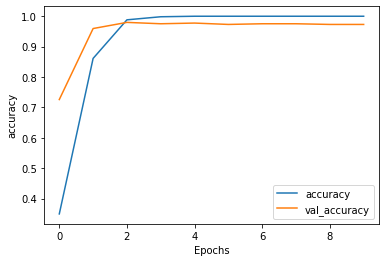

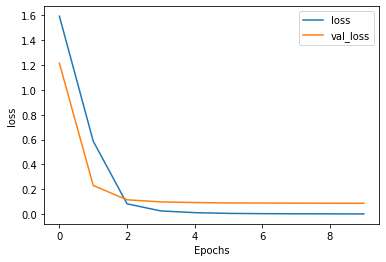

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [13]:
txt = ["A WeWork shareholder has taken the company to court over the near-$1.7bn (£1.3bn) leaving package approved for ousted co-founder Adam Neumann."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
print(pred, labels[np.argmax(pred)])

[[2.5591659e-04 7.7552885e-01 1.6912630e-01 2.6653830e-02 8.0079021e-04
  2.7634259e-02]] bussiness


## Save the model

In [16]:
import pickle

pickle.dump(tokenizer, open('model/news_classification_model_CNN_tokenizer', 'wb'))
model.save('model/news_classification_model_CNN')

INFO:tensorflow:Assets written to: model/news_classification_model_CNN\assets


## Load saved model and Predict

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from spacy.lang.en.stop_words import STOP_WORDS
import pickle

max_length = 200

new_tokenizer = pickle.load(open('model/news_classification_model_CNN_tokenizer','rb'))
new_model = tf.keras.models.load_model('model/news_classification_model_CNN')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 369,734
Trainable params: 369,734
Non-trainable params: 0
_________________________________________________________________


In [19]:

txt = ["A WeWork shareholder has taken the company to court over the near-$1.7bn (£1.3bn) leaving package approved for ousted co-founder Adam Neumann."]
seq = new_tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
print(pred, labels[np.argmax(pred)])

[[2.5591659e-04 7.7552885e-01 1.6912630e-01 2.6653830e-02 8.0079021e-04
  2.7634259e-02]] bussiness
